<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions over time and parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines dimensionality reduction via Proper Orthogonal Decompostion (POD) with multi-fidelity long-short term memory neural (LSTM) network surrogates.


#### (1) **Generation of multi-fidelity dataset**
#### (2) **Dimensionality reduction via POD**
#### (3) **Computing reduced-coordinates via projection**
#### (4) **Training LSTM neural network surrogate model**



#### Import libraries

In [30]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

#### Problem setup
Consider steady groundwater flow in a confined, inhomogeneous aquifer which occupies the domain $\Omega$ with boundary $\Gamma$. 
Assuming that water is incompressible, the governing equations for groundwater flow can be written as the scalar elliptic partial differential equation:
$$
-\nabla \cdot(-T(\mathbf{x}) \nabla h(\mathbf{x}))=g(\mathbf{x}) \text { for all } \quad \mathbf{x} \in \Omega
$$
subject to boundary conditions on $\Gamma=\Gamma_N \cup \Gamma_D$ defined by the constraint equations
$$
h(\mathbf{x})=h_D(\mathbf{x}) \quad \text { on } \Gamma_D \quad \text { and } \quad(-T(\mathbf{x}) \nabla h(\mathbf{x})) \cdot \boldsymbol{n}=q_N(\mathbf{x}) \quad \text { on } \Gamma_N .
$$

Here $T(\mathbf{x})$ is the heterogeneous, depth-integrated transmissivity, $h(\mathbf{x})$ is hydraulic head, $h_D(\mathbf{x})$ is fixed hydraulic head at boundaries with Dirichlet constraints, $g(\mathbf{x})$ is fluid sources and sinks, $q(\mathbf{x})$ is Darcy velocity, $q_N(\mathbf{x})$ is Darcy velocity across boundaries with Neumann constraints and $\Gamma_D \subset \partial \Omega$ and $\Gamma_N \subset \partial \Omega$ define the boundaries comprising of Dirichlet and Neumann conditions, respectively. Following standard FEM practice (see e.g. [19]), eq. (1) is converted into weak form by multiplying by an appropriate test function $w \in H^1(\Omega)$ and integrating by parts, so that
$$
\int_{\Omega} \nabla w \cdot(T(\mathbf{x}) \nabla h) d \mathbf{x}+\int_{\Gamma_N} w q_N(\mathbf{x}) d s=\int_{\Omega} w g(\mathbf{x}) d \mathbf{x}, \quad \forall w \in H^1(\Omega),
$$
where $H^1(\Omega)$ is the Hilbert space of weakly differentiable functions on $\Omega$. To approximate the hydraulic head solution $h(\boldsymbol{x})$, a finite element space $V_\tau \subset H^1(\Omega)$ on a finite element mesh $\mathcal{Q}_\tau(\Omega)$. This is defined by a basis of piecewise linear Lagrange polynomials $\left\{\phi_i(\mathbf{x})\right\}_{i=1}^M$, associated with each of the $M$ finite element nodes. As a result (3) can be rewritten as a system of sparse linear equations
$$
\begin{aligned}
\mathbf{A h}=\mathbf{b} \quad \text { where } \quad A_{i j} & =\int_{\Omega} \nabla \phi_i \cdot T(\mathbf{x}) \nabla \phi_j(\mathbf{x}) d \mathbf{x} \text { and } \\
b_i & =\int_{\Omega} \phi_i(\mathbf{x}) g(\mathbf{x}) d \mathbf{x}-\int_{\Gamma_N} \phi_i(\mathbf{x}) q_N(\mathbf{x}) d s
\end{aligned}
$$
where $\mathbf{A} \in \mathbb{R}^{M \times M}$ and $\mathbf{b} \in \mathbb{R}^M$ are the global stiffness matrix and load vector, respectively. The vector $\mathbf{h}:=\left[h_1, h_2, \ldots, h_M\right] \in \mathbb{R}^M$ is the solution vector of hydraulic head at each node within the finite element mesh so that $h(\mathbf{x})=\sum_{i=1}^M h_i \phi_i(\mathbf{x})$. In our numerical experiments, these equations are solved using the open source general-purpose FEM framework FEniCS. While there are well-established groundwater simulation software packages available, such as MODFLOW  and FEFLOW [19], FEniCS was chosen because of its flexibility and ease of integration with other software and analysis codes.


# DATASET 
The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

In [52]:
X_train = pd.read_csv('./data/X_train.csv').values
y_train = pd.read_csv('./data/y_train.csv').values

X_test = pd.read_csv('./data/X_test.csv').values
y_test = pd.read_csv('./data/y_test.csv').values

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



#### (4ii) Training Fully connected neural network surrogate model

Before introducing the POD in the creation of the model, let us explore how a direct (and therefore simpler) map would perform in this environment \

Let us first try to create a map $T(x) \rightarrow u(x)$ 

Create a NN that takes in inuput the 64 eigenvalues of the transittivity field and returns the hydraulic pressure in the 25 points where the sensors are located 


In [53]:
n_eig = 64
X_train = X_train[:,0:n_eig]
X_test = X_test[:,0:n_eig]

In [61]:
Training = True


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-4)

# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(25, activation='linear'))


if Training:
    # Compile the model
    initial_learning_rate = 0.03
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])
    
    model.save('./models/model_NN_64_sigmoid2.keras')

model = load_model('./models/model_NN_64_sigmoid2.keras')



Epoch 1/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 0.0482 - val_loss: 0.0117 - learning_rate: 0.0300
Epoch 2/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - loss: 0.0121 - val_loss: 0.0123 - learning_rate: 0.0300
Epoch 3/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.0128 - val_loss: 0.0125 - learning_rate: 0.0300
Epoch 4/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.0128 - val_loss: 0.0119 - learning_rate: 0.0300
Epoch 5/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.0128 - val_loss: 0.0123 - learning_rate: 0.0300
Epoch 6/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.0126 - val_loss: 0.0122 - learning_rate: 0.0300
Epoch 7/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.0126 - val_loss: 0.0142 - learning_rate: 0.0300
Epoch 8/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.0128 - val_loss: 0.0128 - learning_rate: 0.0300
Epoch 9/1000
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.0128 - val_loss: 0.012

KeyboardInterrupt: 

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 1.1892e-04
Test accuracy: 0.00012090282689314336
Test rmse: 0.010995582153444325


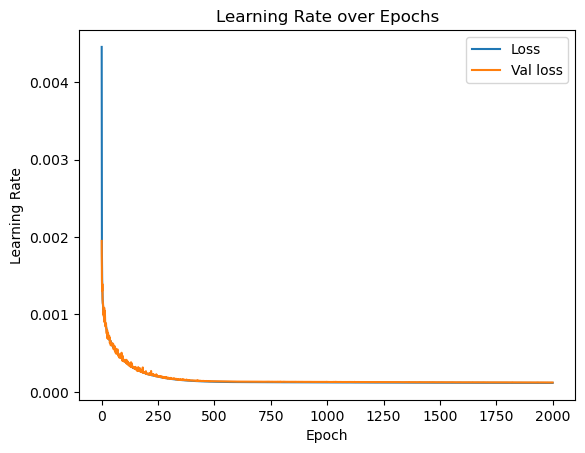

In [55]:
# Evaluate the model on the test set
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

# Optional: Plotting the learning rate and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.show()



In [65]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the base model
base_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=300)

# Wrap the model using MultiOutputRegressor
model = MultiOutputRegressor(base_model, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate and print the mean squared error for each target
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("Mean Squared Error for each target:", mse)

# Calculate and print the overall mean squared error
overall_mse = mean_squared_error(y_test, y_pred)
print("Overall Mean Squared Error:", overall_mse)


Se how it is able to prodict 

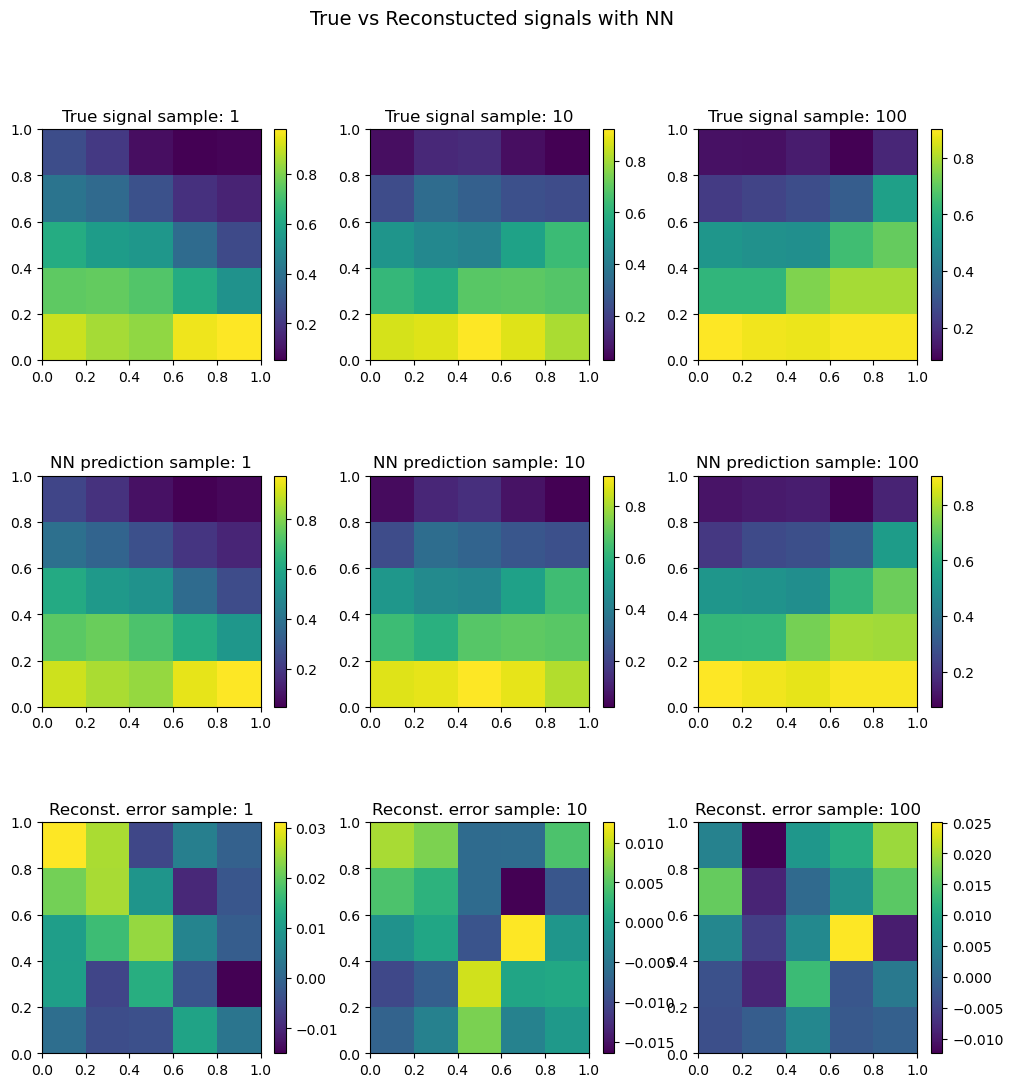

In [56]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with NN'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model(X_test[mode, :].reshape((1, n_eig)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
